In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
pwd

In [2]:
%matplotlib inline
from netCDF4 import Dataset

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn

import os
os.environ ['PROJ_LIB'] = '/home/maria/anaconda3/share/proj'
from mpl_toolkits.basemap import Basemap

from predictability_utils.utils import viz, helpers, io, ion
from predictability_utils.methods.lrlin_method import run_lrlin
from predictability_utils.methods.cca_method import run_cca


# Adjust the I/O paths
root_data = '/home/maria/Documents/HZG-ML-work/Data'
root_results = '/home/maria/Documents/HZG-ML-work/Results'

# Temperature at 2m (EU) detrended ANOMALIES
datei = root_data + "/cru_ts404_t2m_1900-2010.EU.a.dt.nc"
target_data_in = Dataset(datei, 'r').variables['t2m'].__array__().data
lat = Dataset(datei, 'r').variables['lat'].__array__().data
lon = Dataset(datei, 'r').variables['lon'].__array__().data

# Replace missing values with zero
target_data = np.where(target_data_in==9e10, 0, target_data_in)

map_shape = target_data.shape[1:]
print(map_shape)
dim = (map_shape[0])*(map_shape[1])

(72, 82)


# CCA method
- Canonical correlation analysis to identify subspaces $U$, $V$ in source space $X$ and target space $Y$, respectively, such that $(UX)_i$ and $(VY)_i$ are maximally correlated.
- in a second step, establish a (linear) mapping from $VY \approx Q UX$ to predict $VY$ from $UX$.
- predict new $Y$ from $Y \approx V^\dagger Q UX$

In [3]:
# CCA method parameters
calibration_period = train_years = np.arange(14, 71)
n_train_years = len(train_years)

test_years = np.arange(71, 111)
n_test_years = len(test_years)

train_months_set, test_months, names = [[2,3,4],[3,4],[3],[4]], [5,6,7], ["Spr", "AM", "Apr", "May"]

# Number of CCA canonical pairs to be retained
n_latents = 1

# Number of k truncation for the PCA decomposition
n_pca_x, n_pca_y = 2, 2

sst.shape (1332, 76, 116)
sst.shape (1332, 76, 116)
sst.shape (1332, 76, 116)
sst.shape (1332, 76, 116)
sst.shape (1332, 42, 116)
sst.shape (1332, 42, 116)
sst.shape (1332, 42, 116)
sst.shape (1332, 42, 116)
sst.shape (1332, 33, 85)
sst.shape (1332, 33, 85)
sst.shape (1332, 33, 85)
sst.shape (1332, 33, 85)
swvl1.shape (1332, 37, 42)
swvl1.shape (1332, 37, 42)
swvl1.shape (1332, 37, 42)
swvl1.shape (1332, 37, 42)


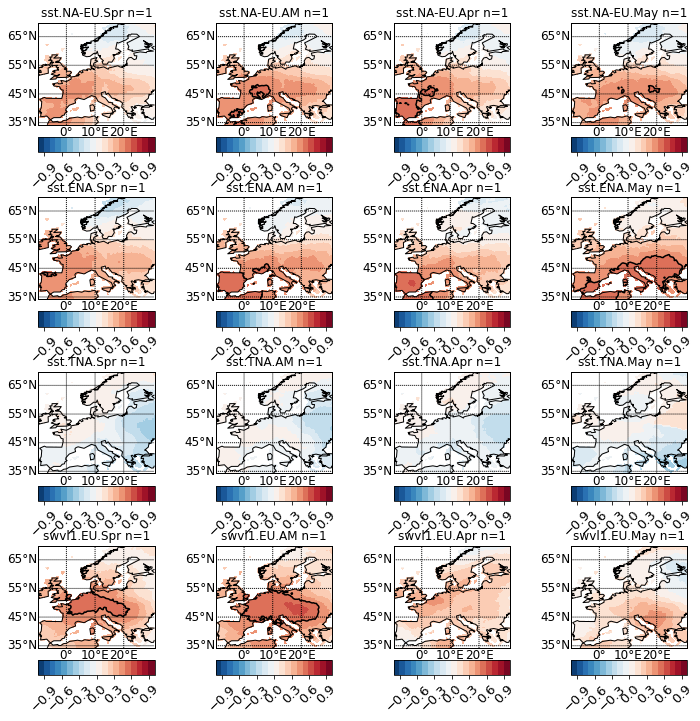

In [4]:
# Run CCA simple model and plot correlation to target variable for all seasons and all predictors

import warnings; warnings.simplefilter('ignore')

fields = ["sst", "sst", "sst", "swvl1"]
regions = ["NA-EU", "ENA", "TNA", "EU"]

fig = plt.figure(figsize=(12,12))

for i, (field, region) in enumerate (zip(fields, regions)):
    for k in range(len(train_months_set)):
        
        train_months = train_months_set[k]
        season = names[k]
        source_data_in, _ = ion.data_load(field, region, 'a', root_data)
        source_data = np.where(source_data_in==9e10, 0, source_data_in)
        
        # Create index for period selection
        idcs = helpers.split_train_data(train_months, test_months, train_years, test_years)
        idx_source_train, idx_target_train, idx_source_test, idx_target_test = idcs
        
        anomaly_corrs, params_cca = run_cca(source_data, target_data, n_latents, idcs, 
                                int(n_pca_x), int(n_pca_y), if_plot=False, map_shape=map_shape)
        
        plt.subplot(4,4, k + 1 + i*4)
        viz.visualize_ACC(anomaly_corrs, lat, lon, map_shape, f"{field}.{region}.{season} n=1")

# simple low-rank linear prediction (pixel MSEs) 

- set up simple model $Y = W X$ with $W = U V$
- low-rank: if $Y \in \mathbb{R}^N, X \in \mathbb{R}^M$, then $W \in \mathbb{R}^{N \times M}$, but $U \in \mathbb{R}^{N \times k}, V \in \mathbb{R}^{k \times M}$ with $k << M,N$ !
- low-rank structure saves us parameters: $M N$ parameters in $W$, but only $N k + k M$ in $U$ and $V$, helps prevent overfitting on low samples size

In [5]:
# PCA method parameters
calibration_period = train_years = np.arange(14, 71)
n_train_years = len(train_years)

test_years = np.arange(71, 111)
n_test_years = len(test_years)

train_months_set, test_months, names = [[2,3,4],[3,4],[3],[4]], [5,6,7], ["Spr", "AM", "Apr", "May"]
n_set = np.arange(len(train_months_set))+1

# Number of PCA truncation
n_min, n_max = 1, 5

sst.shape (1332, 76, 116)
sst.shape (1332, 76, 116)
sst.shape (1332, 76, 116)
sst.shape (1332, 76, 116)
sst.shape (1332, 76, 116)
sst.shape (1332, 76, 116)
sst.shape (1332, 76, 116)
sst.shape (1332, 76, 116)
sst.shape (1332, 76, 116)
sst.shape (1332, 76, 116)
sst.shape (1332, 76, 116)
sst.shape (1332, 76, 116)
sst.shape (1332, 76, 116)
sst.shape (1332, 76, 116)
sst.shape (1332, 76, 116)
sst.shape (1332, 76, 116)
sst.shape (1332, 76, 116)
sst.shape (1332, 76, 116)
sst.shape (1332, 76, 116)
sst.shape (1332, 76, 116)


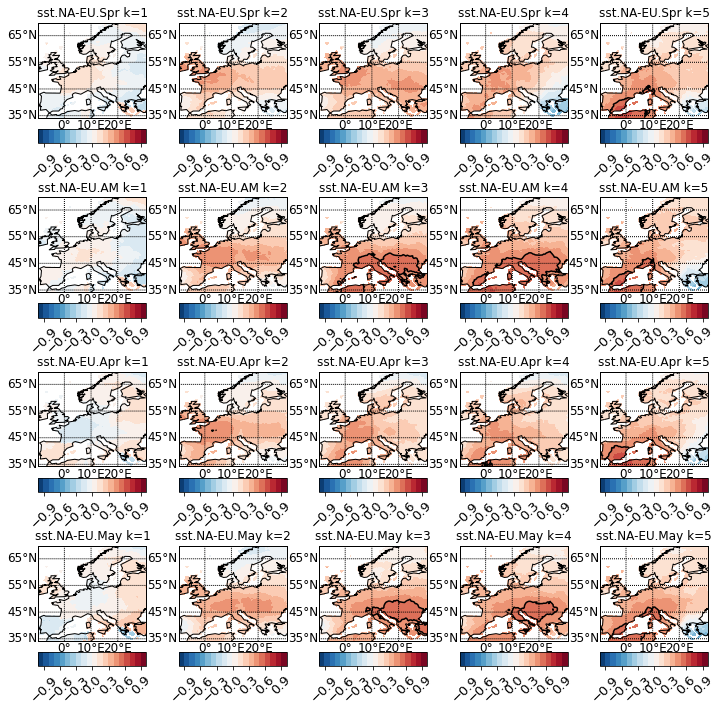

In [6]:
# Run PCA-MLR model and plot correlation to target variable for 5>k>=1
# Here demonstrate only the predictor SST-NA and plot in each row a different season

fig = plt.figure(figsize=(12,12))

for i, k in enumerate(n_set):
    for n_latent in np.arange(n_min, n_max+1):
        
        train_months = train_months_set[k-1]
        season = names[k-1]
        
        # Import predictor field
        field, region = "sst", "NA-EU"
        source_data_in, _ = ion.data_load(field, region, 'a', root_data)
        source_data = np.where(source_data_in==9e10, 0, source_data_in)
        
        # Create index for period selection
        idcs = helpers.split_train_data(train_months, test_months, train_years, test_years)
        idx_source_train, idx_target_train, idx_source_test, idx_target_test = idcs
        
        n_pca_x = n_pca_y = n_latent
        anomaly_corrs, params_lrlin = run_lrlin(source_data, target_data, 
                                    n_pca_x, n_pca_y, n_latent, idcs, if_plot=False, map_shape=map_shape, 
                                    n_epochs=5000, lr=1e-3, batch_size=None);

        plt.subplot(4,n_max, n_latent+i*5)
        viz.visualize_ACC(anomaly_corrs, lat, lon, map_shape, f"{field}.{region}.{season} k={n_latent}")